In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
pd.read_table('ratings_train.txt')

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [47]:
pd.read_table('ratings_test.txt')

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [48]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [49]:
print('훈련용 리뷰 개수:', len(train_data)) 

훈련용 리뷰 개수: 150000


In [50]:
train_data[:5]
#id, document, label의 총 3개의 열로 구성되어 있음
#id는 감성분류 수행에 도움되지 않으므로 이를 제외하고 학습하는 모델이 되어야 함
#또한 영어랑 다르게 띄어쓰기를 하지 않아도 한국어의 특성으로 인해 이해가 가능

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [51]:
print('테스트용 리뷰 개수 :', len(test_data))

테스트용 리뷰 개수 : 50000


In [52]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [53]:
#trian_data데이터 중복 유무 확인 후 중복 샘플 제거
#document 열과 label열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()


(146182, 2)

In [54]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [55]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


<AxesSubplot:>

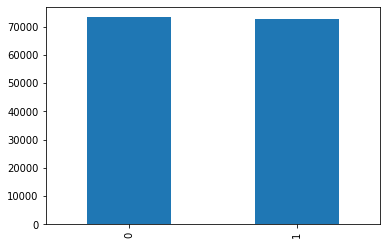

In [56]:
#긍정, 부정 유무가 기재되어 있는  레이블 값 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [57]:
#레이블 당 개수 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [58]:
print(train_data.isnull().values.any())

True


In [59]:
#null값이 있다고 했으니 어떤 열인지 확인 후 제거
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [60]:
#null값이 있는 위치 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [61]:
train_data = train_data.dropna(how = 'any') #null값 존재하는 행 제거
print(train_data.isnull().values.any()) #null있나 재 확인

False


In [62]:
print(len(train_data))

146182


In [63]:
#데이터 전처리
#알파벳과 공백 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'

print(re.sub(r'[^a-zA-Z ]', '', eng_text))


do you expect people to read the FAQ etc and actually accept hard atheism


In [64]:
#한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
train_data[:5]

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [65]:
train_data['document']=train_data['document'].str.replace('^ +',"") 
#한글이 없는 리뷰일시 빈 값이 되었는데 이 공백(white space)데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [66]:
train_data.loc[train_data['document'].isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [67]:
#빈 샘플 제거
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [68]:
test_data.drop_duplicates(subset = ['document'], inplace=True) #중복이 있다면 중복제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "") #정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플 개수 :', len(test_data))

전처리 후 테스트용 샘플 개수 : 48852


In [69]:
#토큰화
#불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [70]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)#stem을 통해 일정 수준 정규를 수행 이런->이렇다, 만드는->만들다

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [71]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)# 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] #불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [40:49<00:00, 59.36it/s] 


In [72]:
print(X_train[:3])

[['아더', '빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [73]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentnece = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [13:51<00:00, 58.75it/s] 


In [74]:
#정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [75]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '좋다': 6, '다': 7, '너무': 8, '하': 9, '정말': 10, '재밌다': 11, '적': 12, '되다': 13, '같다': 14, '있다': 15, '만': 16, '진짜': 17, '않다': 18, '로': 19, '아니다': 20, '에서': 21, '내': 22, '평점': 23, '그': 24, '최고': 25, '인': 26, '나': 27, '연기': 28, '생각': 29, '스토리': 30, '점': 31, '게': 32, '이영화': 33, '드라마': 34, '감동': 35, '사람': 36, '만들다': 37, '고': 38, '요': 39, '나오다': 40, '아깝다': 41, '이런': 42, '지': 43, 'ㅋㅋ': 44, '보고': 45, '재미있다': 46, '배우': 47, '왜': 48, '감독': 49, '때': 50, '네': 51, '들다': 52, '하고': 53, '그냥': 54, '아': 55, '재미없다': 56, '시간': 57, '까지': 58, '못': 59, '중': 60, '것': 61, '지루하다': 62, '뭐': 63, '가다': 64, '재미': 65, '쓰레기': 66, '말': 67, '면': 68, '주다': 69, '본': 70, '모르다': 71, '작품': 72, '알다': 73, '더': 74, '오다': 75, '거': 76, '자다': 77, '그렇다': 78, '사랑': 79, '마지막': 80, '저': 81, '대': 82, '정도': 83, '화': 84, 'ㅠㅠ': 85, '이나': 86, '많다': 87, '완전': 88, 'ㅋㅋㅋ': 89, '처음': 90, '라': 91, 'ㅋ': 92, '안되다': 93, '개': 94, '액션': 95, '이렇게': 96, '주인공': 97, '니': 98, '최악': 99, '내용': 100, '느낌': 101, '싶다': 102

In [76]:
#적은 비중의 단어들 확인  (등장빈도수 3회미만)
threshold = 3
total_cnt = len(tokenizer.word_index) #단어 수
rare_cnt = 0 #3회 미만
total_freq = 0 #전체 단어 빈도수 총 합
rare_freq = 0 #적은 비중 단어 빈도수 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value< threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수 : %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt/total_cnt)*100)
print('전체 문장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 46503
등장 빈도가 2번 이하인 희귀 단어 수 : 25474
단어 집합에서 희귀 단어의 비율 : 54.77926155301809
전체 문장 빈도에서 희귀 단어 등장 빈도 비율 : 1.9761734039734433


In [77]:
#0번 패딩 토큰을 고려해 +1해서 희귀 단어 제거
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21030


In [78]:
#정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [79]:
print(X_train[:3]) #정수인코딩 진행 확인

[[9879, 11447, 17, 249, 661], [1062, 468, 45, 605, 1, 407, 1509, 28, 1077, 680, 18], [214, 1719, 569, 3848, 2, 226, 7]]


In [80]:
y_train = np.array(train_data['label'])
y_train = np.array(test_data['label'])

In [81]:
#빈샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] #길이가 0인 샘플들 인덱스
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145082
48743


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.


리뷰의 최대 길이 : 68
리뷰 평균 길이 : 10.76081112750031


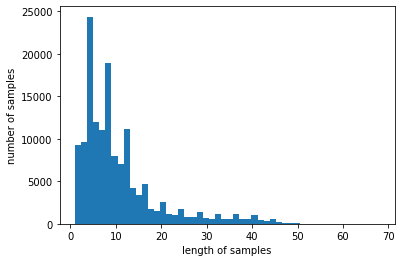

In [82]:
#패딩(다른 길이의 샘플들의 길이를 동일하게 맞춰줌)
#데이터의 전체 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [83]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count/ len(nested_list))*100))

In [84]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율 : 94.39834024896265


In [85]:
#전체 훈련 데이터의 94%가 30이하의 길이를 가지니 모든 샘플의 길이를 30으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [86]:
#다대일구조LSTM모델 사용하기
from tensorflow.keras.layers import Embedding,Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc], batch_size=64, validation_split=0.2)
             

ValueError: Data cardinality is ambiguous:
  x sizes: 116065
  y sizes: 48743
Please provide data which shares the same first dimension.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n테스트 정확도 : %.4f"%(loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
#리뷰 예측 
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True)#토큰화
    new_sentence = [word for word in new_sentence if not word in sotpwords]
    encoded = tokenizer.text_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_mode.predict(pad_new))
    
    if(score>0,5):
        print("{:.2f}%확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}%확률로 부정 리뷰입니다.\n".format(score * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')